# **SeisMIC** Tutorial
In the following, we will go through a simple example to compute a ambient noise correlations and monitor velocity changes using **SeisMIC**.

The source code is hosted here: [SeisMIC](https://github.com/PeterMakus/SeisMIC).

The documentation, which this notebook is based upon is located here:
[SeisMIC Documentation](https://petermakus.github.io/SeisMIC/).

Without further ado, we'll dive right into it starting with data download.

## 1. Download the raw data
**SeisMIC** uses [obspy](https://docs.obspy.org/) to download data from FDSN servers. As an exercise, we will download
data from one channel of the station `X9.IR1` to investigate the coseismic velocity change caused by the M7.2 2016 Zhupanov earthquake
(see [Makus et. al., 2023](https://doi.org/10.1029/2022JB025738)).

To download the data, we will use the `seismic.trace_data.waveform.Store_Client` class and its method `download_waveforms_mdl()`.

In [94]:
import os

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from seismic.trace_data.waveform import Store_Client

# Get notebook path for future reference of the database:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

root = os.path.join(ipynb_path, 'data')
os.makedirs(root, exist_ok=True)

starttime = UTCDateTime(2016, 1, 25)
endtime = UTCDateTime(2016, 2, 5)
network = 'X9'
station = 'IR1'


c = Client('GEOFON')
sc = Store_Client(c, root, read_only=False)
sc.download_waveforms_mdl(
    starttime, endtime, clients=[c], network=network,
    station=station, location='*', channel='HHE')


[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://geofon.gfz-potsdam.de.
[2023-03-29 13:07:40,858] - obspy.clients.fdsn.mass_downloader - INFO

Some notes about this:
1. The method `download_waveforms_mdl()` expects a list of clients as input.
2. All arguments accept wildcards

If everything worked fine. This should have created a folder called `data/mseed` and `data/inventory`. Let's check

In [95]:
os.listdir('./data/')

['inventory', 'vel_change', 'figures', 'log', 'mseed', 'corr']

## 2. Compute Correlations
That seems to have worked, so we are ready to use this raw data to compute ambient noise correlations.

### 2.1 Parameters
Parameters are provided as a `yaml` file or a `dict` object. This tutorial comes with an yaml file to process the data. Let's have a short look at it using bash.

In [96]:
!cat params.yaml

#### Project wide parameters
# lowest level project directory
proj_dir : 'data'
# directory for logging information
log_subdir : 'log'
# levels:
# 'DEBUG', 'INFO', 'WARNING', 'ERROR', or 'CRITICAL'
log_level: 'INFO'
# folder for figures
fig_subdir : 'figures'


#### parameters that are network specific
net:
    # list of stations used in the project
    # type: list of strings or string, wildcards allowed
    network : 'X9'
    station : 'IR1'

#### parameters for correlation (emperical Green's function creation)
co:
    # subdirectory of 'proj_dir' to store correlation
    # type: string
    subdir : 'corr'
    # times sequences to read for cliping or muting on stream basis
    # These should be long enough for the reference (e.g. the standard
    # deviation) to be rather independent of the parts to remove
    # type: string
    read_start : '2016-01-25 00:00:01.0'
    read_end : '2016-02-05 00:00:00.0'
    # type: float [seconds]
    # The longer the faster, but higher RAM usage.
  

Each of the parameters is described in the [Documentation](url.to.doc.org).

To start the computation of the correlation we will use `MPI` and a simple python script, which could look like this:

In [97]:
!cat correlate.py

from time import time

from obspy.clients.fdsn import Client

from seismic.correlate.correlate import Correlator
from seismic.trace_data.waveform import Store_Client

# Path to the paramter file we created in the step before
params = 'params.yaml'
# You don't have to set this (could be None)
client = Client('IRIS')
# root is the same as proj_dir in params.yaml
root = 'data'
sc = Store_Client(client, root)

c = Correlator(sc, options=params)
print('Correlator initiated')
x = time()
st = c.pxcorr()
print('Correlation finished after', time()-x, 'seconds')


## 2.2 Start correlation
To start the correlation, we will use the `mpirun` command in bash:

In [99]:
import os
# This gives number of threads, usually twice as many as physical cores
ncpus = os.cpu_count()//2
!mpirun -n $ncpus python correlate.py

Correlator initiated
Correlator initiated
Correlator initiated
  0%|          | 0/11 [00:00<?, ?it/s]Correlator initiated
Correlator initiated
Correlator initiated
100%|██████████| 11/11 [01:59<00:00, 10.86s/it]
Correlation finished after 114.92050457000732 seconds
Correlation finished after 119.17398571968079 seconds
Correlation finished after 119.53113174438477 seconds
Correlation finished after 119.53197979927063 seconds
Correlation finished after 114.9229199886322 seconds
Correlation finished after 119.9829752445221 seconds


Now let's have a look at those correlations. To do so, we use the `CorrelationDataBase` object.
All correlations are saved in the folder `data/corr` as defined in our params.yaml file.

In [109]:
from seismic.db.corr_hdf5 import CorrelationDataBase

with CorrelationDataBase(f'data/corr/{network}-{network}.{station}-{station}.h5', mode='r') as cdb:
    # find the available labels
    print(list(cdb.keys()))

['co', 'stack_86398', 'subdivision']


**SeisMIC's** standard labels are `'subdivision` for the correlations of corr_len and `stack_*stacklen*` for the stack (with *stacklen* being the length of the stack in seconds).

**SeisMIC** uses some sort of "combined seed codes" structured as above.

In [120]:
with CorrelationDataBase(f'data/corr/{network}-{network}.{station}-{station}.h5', mode='r') as cdb:
    # find the available labels
    print(cdb.get_available_channels(
        tag='stack_86398', network=f'{network}-{network}', station=f'{station}-{station}'))
    cst = cdb.get_data(f'{network}-{network}', f'{station}-{station}', 'HHE-HHE', 'subdivision')
print(type(cst))

['HHE-HHE', 'HHN-HHN', 'HHZ-HHZ']
<class 'seismic.correlate.stream.CorrStream'>


`cst` is now a `CorrStream` - an obspy based object to handle correlations. We can plot those in a section plot for example by time:

<Axes: xlabel='$\\tau$ [s]'>

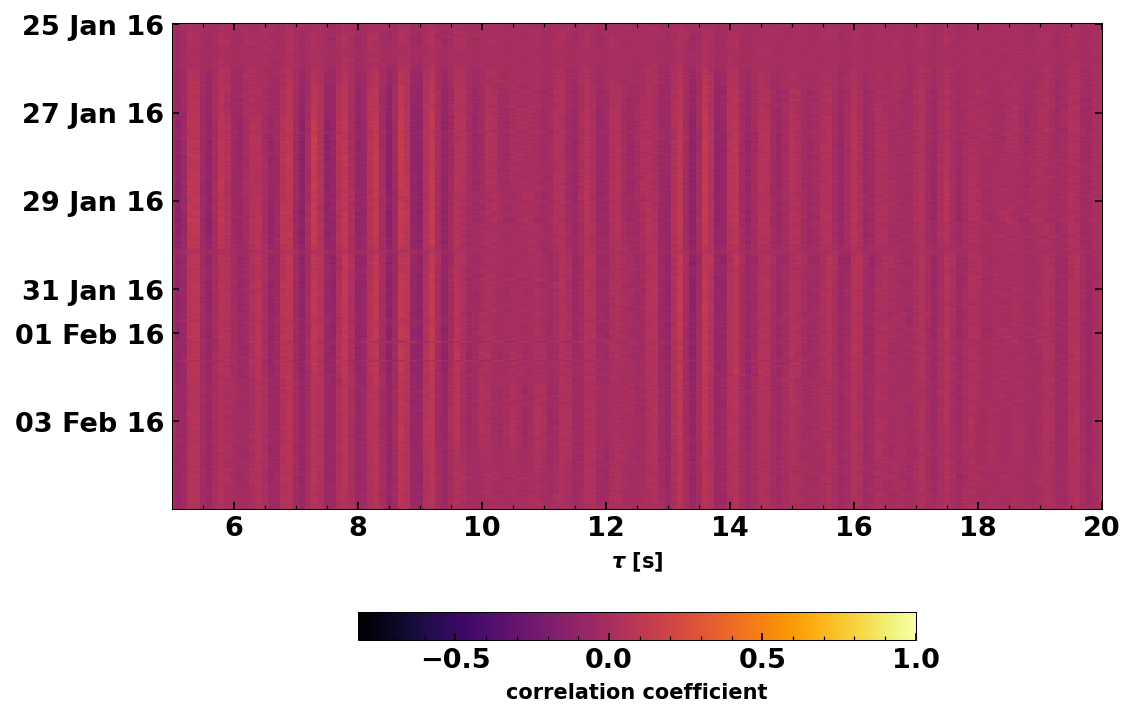

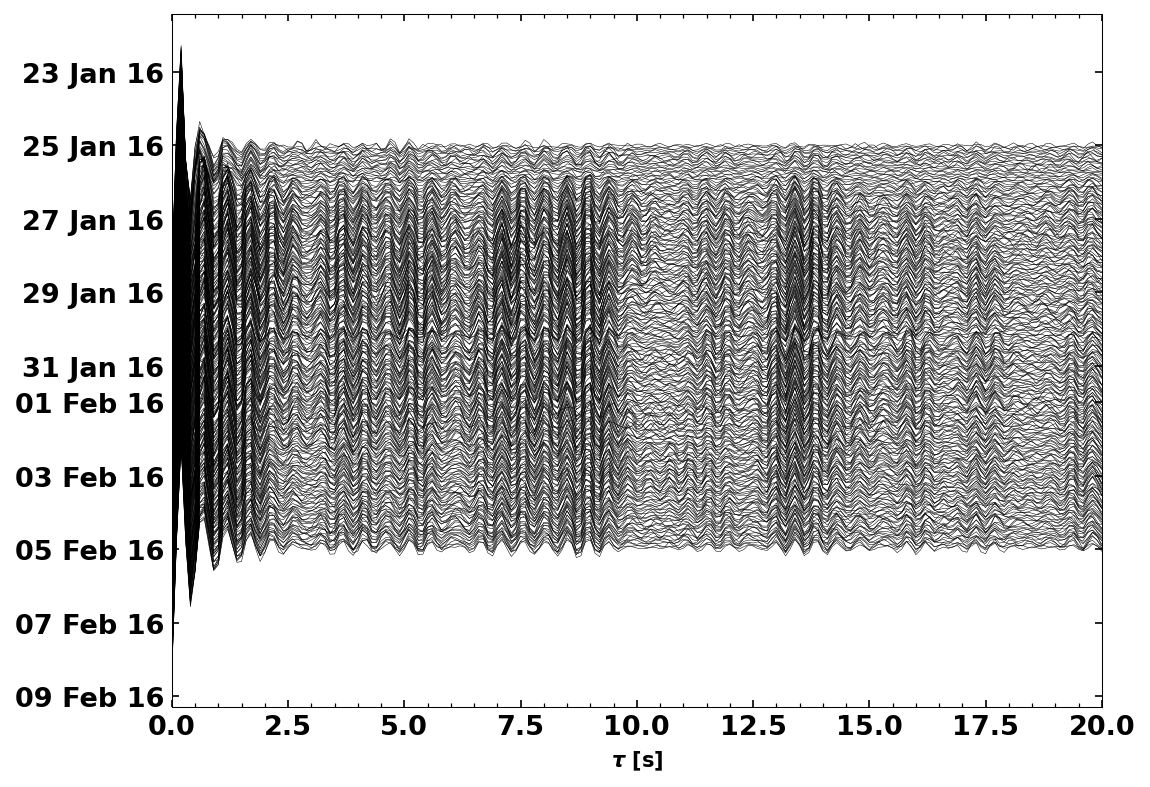

In [123]:
cst.plot(timelimits=[5, 20])
cst.plot(scalingfactor=3, timelimits=[0, 20], type='section')

If you look very very closely, you can see a slight time shift in the late coda on January 30th. This time shift is associated to the Zhupanov earthquake. We will try to quantify the velocity change in the following.

We can also look at a single correlation:

<Axes: xlabel='Lag Time [s]', ylabel='Correlation'>

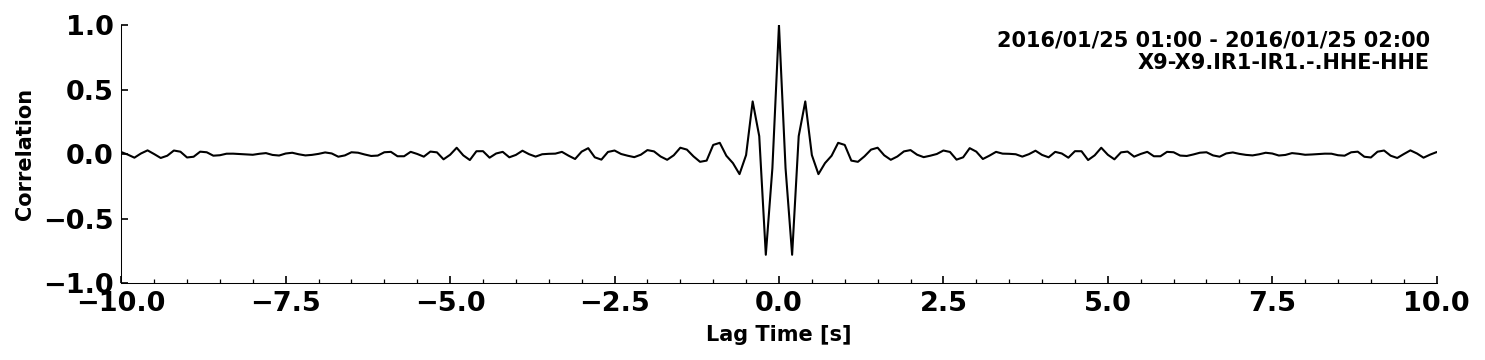

In [122]:
cst[1].plot(tlim=[-10,10])

## 3. Monitoring
Similarly to the Correlation we can start the monitor via a simple script:

In [115]:
!cat monitor.py

from seismic.monitor.monitor import Monitor

yaml_f = 'params.yaml'
m = Monitor(yaml_f)
m.compute_velocity_change_bulk()


In [116]:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

!mpirun -n $ncpus python ./monitor.py

2023-03-29 13:14:16,951 - INFO - Found correlation data for the following station and network combinations ['X9-X9.IR1-IR1']
  0%|          | 0/1 [00:00<?, ?it/s]2023-03-29 13:14:16,956 - INFO - Computing velocity change for file: data/corr/X9-X9.IR1-IR1.h5 and channel:HHE-HHE
2023-03-29 13:14:16,959 - INFO - Found correlation data for the following station and network combinations ['X9-X9.IR1-IR1']
  0%|          | 0/1 [00:00<?, ?it/s]2023-03-29 13:14:16,962 - INFO - Computing velocity change for file: data/corr/X9-X9.IR1-IR1.h5 and channel:HHZ-HHZ
2023-03-29 13:14:16,966 - INFO - Found correlation data for the following station and network combinations ['X9-X9.IR1-IR1']
0it [00:00, ?it/s]
2023-03-29 13:14:16,980 - INFO - Found correlation data for the following station and network combinations ['X9-X9.IR1-IR1']
0it [00:00, ?it/s]
2023-03-29 13:14:16,998 - INFO - Found correlation data for the following station and network combinations ['X9-X9.IR1-IR1']
  0%|          | 0/1 [00:00<?, 

### Make a first plot to get an idea of *dv/v*
We can use SeisMIC's inbuilt plotting function for that.

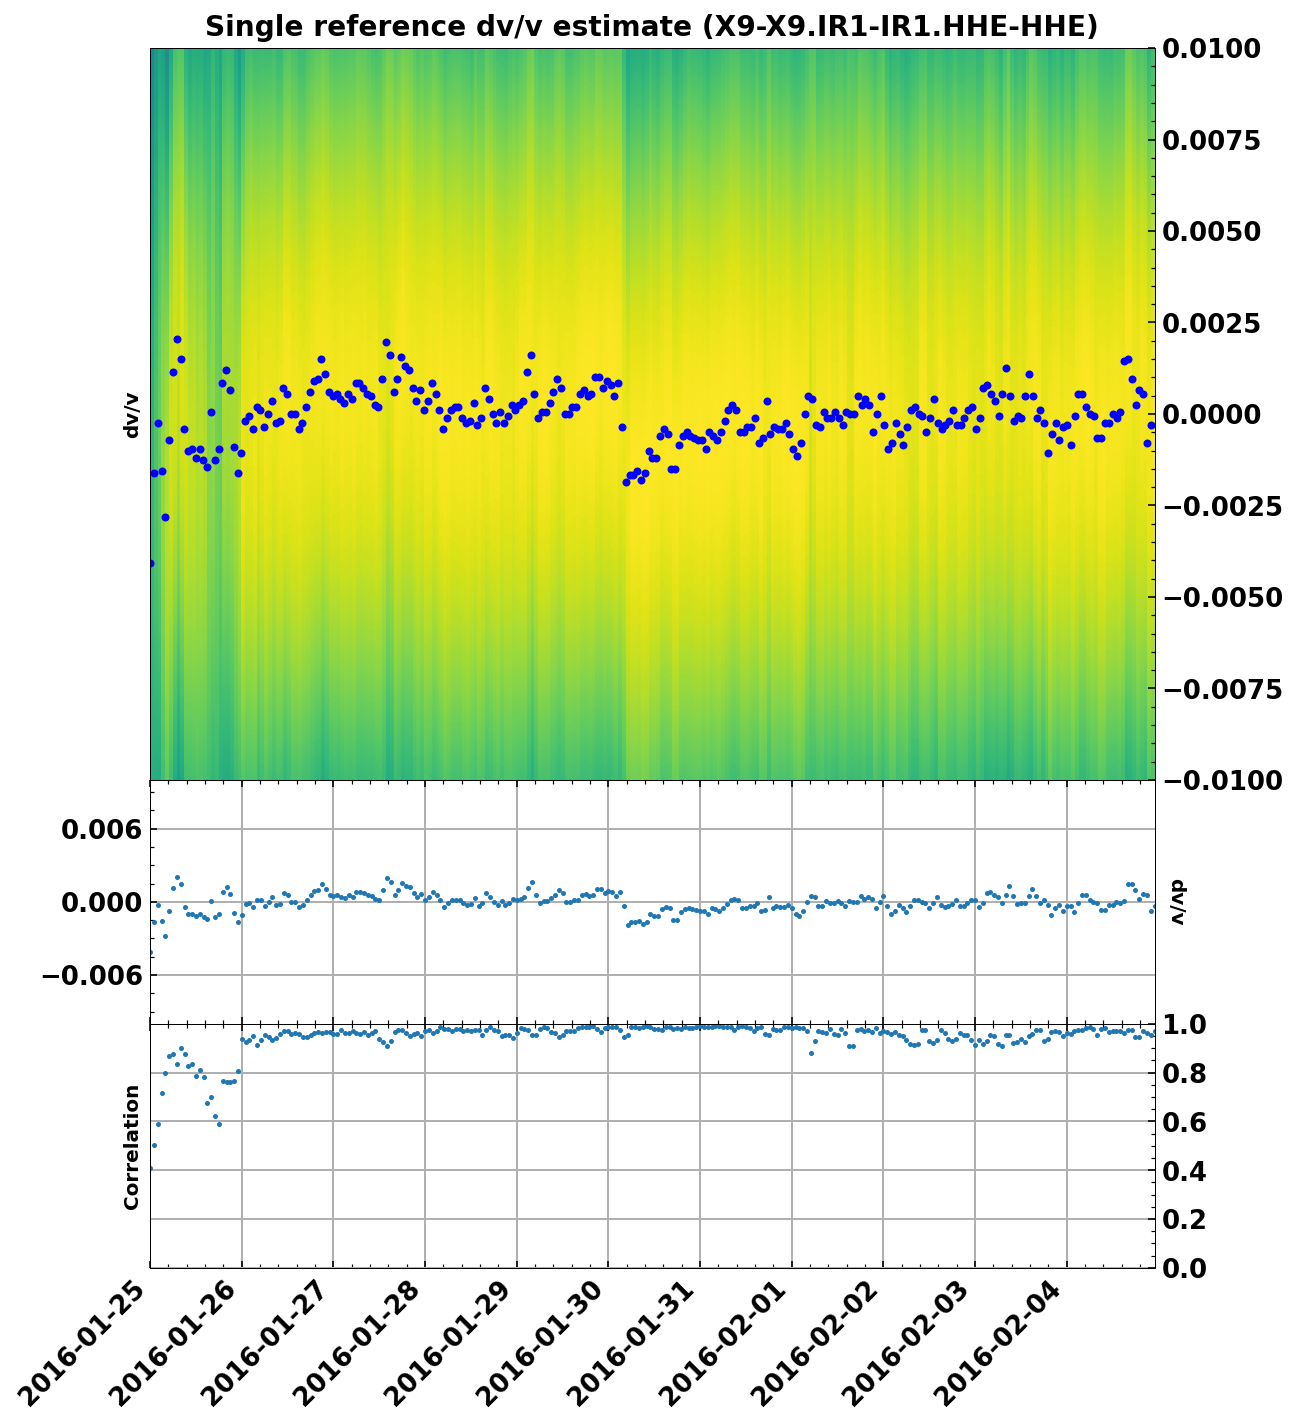

In [119]:
from seismic.monitor.dv import read_dv
dv = read_dv(f'data/vel_change/DV-{network}-{network}.{station}-{station}.HHE-HHE.npz')
dv.plot(ylim=(-0.01,0.01))

Even with comparably little data, we can see the velocity drop on January 30th. Note that due to the high energy noise, we are able to retrieve a very high resolution estimate of *dv/v*.

## Make the plot look a little nicer
The plot above is very good if you just want to understand what is going on, but maybe it is not necessarily something you would want to put into a publication. Here is a code that makes the plot look like in the above mentioned publication